In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import seaborn as sns
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

import warnings
from time import time
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras import metrics

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as sm

In [122]:
dataBlocks = []
for num in range(1,112):
    df = pd.read_csv("dane/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    dataBlocks.append(df)
data = pd.concat(dataBlocks, ignore_index=True)

In [123]:
data['date_time'] = pd.to_datetime(data['day'])
data['energy_sum'] = pd.to_numeric(data['energy_sum'], errors='coerce')
data = data.dropna(subset=['energy_sum'])

In [124]:
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)

In [125]:
data = data.loc[:,['date_time','energy_sum', 'year','quarter','month','day']]
data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [126]:
data.head()

,date_time,energy_sum,year,quarter,month,day,weekday
0,2011-11-23,1.283,2011,4,11,23,1
1,2011-11-23,7.408,2011,4,11,23,1
2,2011-11-23,3.036,2011,4,11,23,1
3,2011-11-23,5.619,2011,4,11,23,1
4,2011-11-23,5.798,2011,4,11,23,1


In [127]:
data.tail()

,date_time,energy_sum,year,quarter,month,day,weekday
3484824,2014-02-28,0.225,2014,1,2,28,1
3484825,2014-02-28,0.096,2014,1,2,28,1
3484826,2014-02-28,0.050,2014,1,2,28,1
3484827,2014-02-28,0.144,2014,1,2,28,1
3484828,2014-02-28,0.000,2014,1,2,28,1


In [128]:
print('Liczba wierszy i kolumn:', data.shape)
print('Najstarsza data:', data.date_time.min())
print('Najnowsza data:', data.date_time.max())

Liczba wierszy i kolumn: (3484829, 7)
Najstarsza data: 2011-11-23 00:00:00
Najnowsza data: 2014-02-28 00:00:00


In [129]:
energyPerDay = data.groupby('date_time')[['energy_sum']].sum()
data.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
energyPerDay.reset_index()
data = data.merge(energyPerDay, on='date_time', how='left')
data.drop(['energy_sum_x'], inplace=True, axis=1)
data.rename(columns={'energy_sum_y':'energy_sum'}, inplace=True)

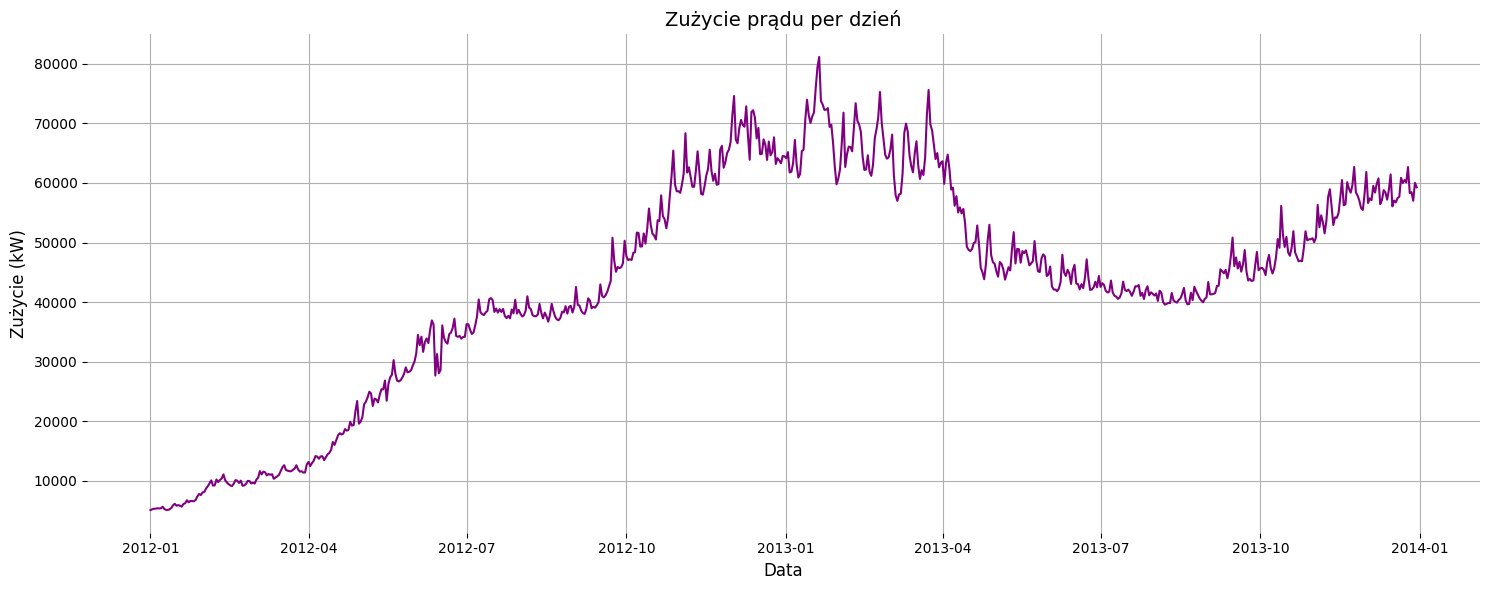

In [130]:
data1 = data[(data.date_time >= '2012-01-01') & (data.date_time < '2013-12-31')]

plt.figure(figsize=(15,6))
plt.plot(data1.date_time, data1.energy_sum, color='purple')
plt.ylabel('Zużycie (kW)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.title('Zużycie prądu per dzień', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

In [131]:
dataset = data.energy_sum.values.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [132]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [133]:
X_train, Y_train = create_dataset(train, 30)
X_test, Y_test = create_dataset(test, 30)
print(X_train.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(X_test.shape)

(549, 30)
(218, 30)
(549, 1, 30)
(218, 1, 30)


In [134]:
model = Sequential()
model.add(LSTM(units=1000, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid', kernel_constraint=MaxNorm(3)))

#sgd = SGD(learning_rate=0.2, momentum=0.9)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.compile(loss=tf.keras.losses.MeanSquaredError(reduction="none"), optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train, Y_train, epochs=100, batch_size=50, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

c:\Users\3764\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
11/11 - 6s - 569ms/step - loss: 0.0677 - val_loss: 0.0256
Epoch 2/100
11/11 - 1s - 105ms/step - loss: 0.0674 - val_loss: 0.0254
Epoch 3/100
11/11 - 1s - 107ms/step - loss: 0.0673 - val_loss: 0.0251
Epoch 4/100
11/11 - 1s - 126ms/step - loss: 0.0672 - val_loss: 0.0248
Epoch 5/100
11/11 - 1s - 109ms/step - loss: 0.0672 - val_loss: 0.0246
Epoch 6/100
11/11 - 1s - 98ms/step - loss: 0.0671 - val_loss: 0.0243
Epoch 7/100
11/11 - 1s - 101ms/step - loss: 0.0671 - val_loss: 0.0240
Epoch 8/100
11/11 - 1s - 111ms/step - loss: 0.0670 - val_loss: 0.0238
Epoch 9/100
11/11 - 1s - 104ms/step - loss: 0.0670 - val_loss: 0.0235
Epoch 10/100
11/11 - 1s - 120ms/step - loss: 0.0669 - val_loss: 0.0233
Epoch 11/100
11/11 - 1s - 127ms/step - loss: 0.0668 - val_loss: 0.0230
Epoch 12/100
11/11 - 1s - 105ms/step - loss: 0.0667 - val_loss: 0.0227
Epoch 13/100
11/11 - 1s - 108ms/step - loss: 0.0666 - val_loss: 0.0224
Epoch 14/100
11/11 - 1s - 103ms/step - loss: 0.0665 - val_loss: 0.0221
Epoch 15/100
11/

In [135]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 1, 1000)        │     4,124,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1, 1000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 1, 500)         │     3,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 1, 500)         │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1, 500)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 100)            │       240,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,737,004 (71.48 MB)

 Trainable params: 9,368,501 (35.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,368,503 (35.74 MB)

In [136]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Średni błąd bezwzględny na zbiorze testowym:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym: ',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Średni błąd bezwzględny na zbiorze treningowym:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Średni błąd bezwzględny na zbiorze testowym: 3531.719548363951
Pierwiastek z błędu średniokwadratowego na zbiorze testowym:  4545.05346345783
Średni błąd bezwzględny na zbiorze treningowym: 2066.7160716079443
Pierwiastek z błędu średniokwadratowego na zbiorze testowym: 2765.7011589574804


In [137]:
print("R2 score =", round(sm.r2_score(Y_test[0], test_predict[:,0]), 2))

R2 score = 0.85


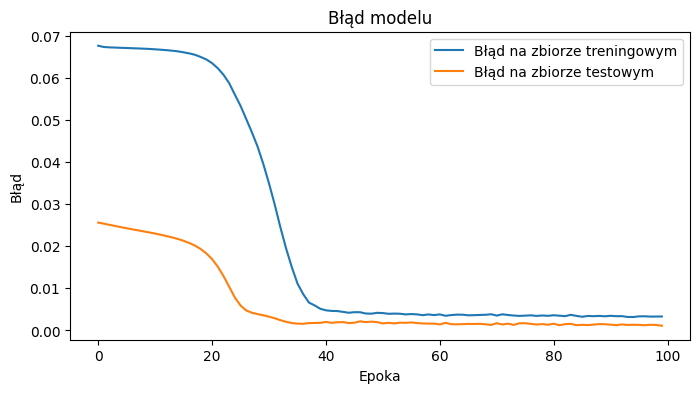

In [138]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Błąd na zbiorze treningowym')
plt.plot(history.history['val_loss'], label='Błąd na zbiorze testowym')
plt.title('Błąd modelu')
plt.ylabel('Błąd')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()

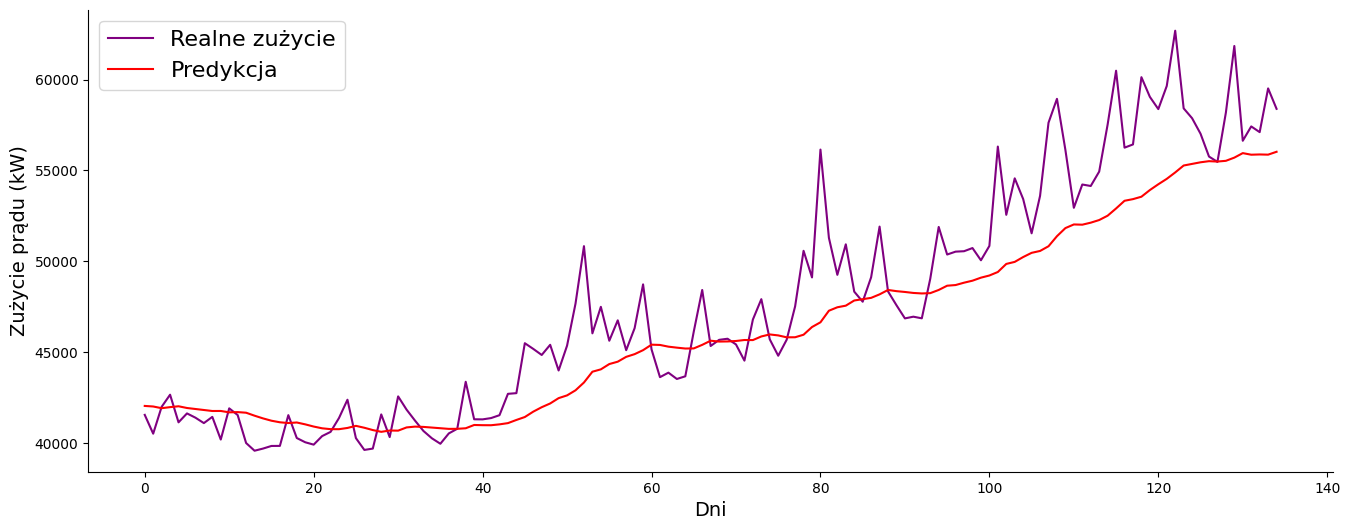

In [139]:
aa=[x for x in range(135)]
                    
plt.figure(figsize=(15,6))
plt.plot(aa, Y_test[0][:135], label="Realne zużycie", color='purple')
plt.plot(aa, test_predict[:,0][:135], label="Predykcja", color='red')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Zużycie prądu (kW)', size=14)
plt.xlabel('Dni', size=14)
plt.legend(fontsize=16)
plt.show()

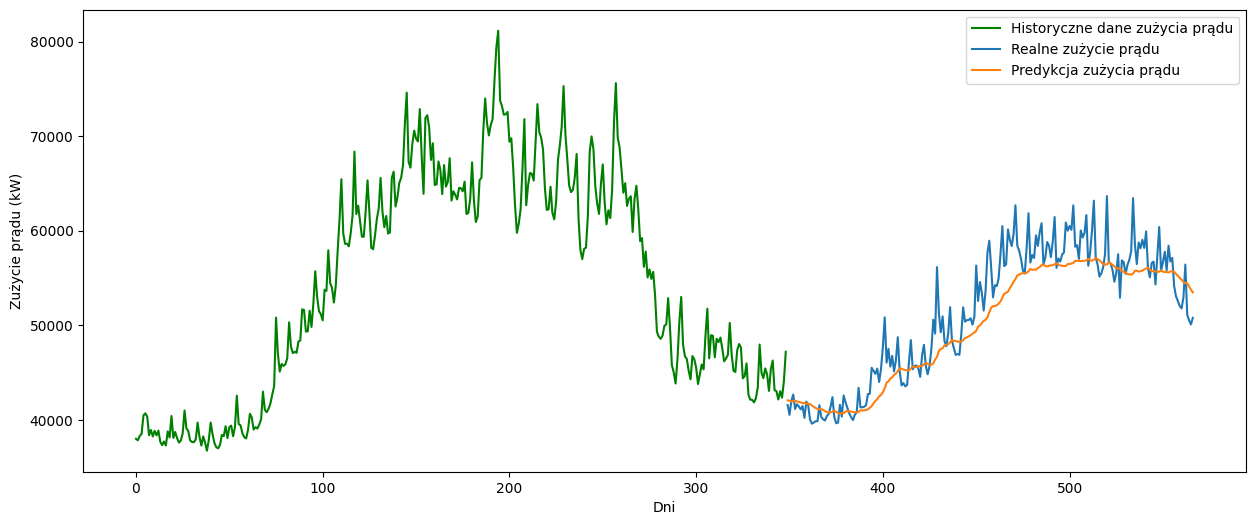

In [140]:
aa=[x for x in range(30)]
plt.figure(figsize=(15,6))
plt.plot(np.arange(0, len(Y_train[0][200:550])), Y_train[0][200:550], 'g', label="Historyczne dane zużycia prądu")
plt.plot(np.arange(len(Y_train[0][200:550]), len(Y_train[0][200:550]) + len(Y_test[0])), Y_test[0], label="Realne zużycie prądu")
plt.plot(np.arange(len(Y_train[0][200:550]), len(Y_train[0][200:550]) + len(Y_test[0])), test_predict[:,0], label="Predykcja zużycia prądu")
plt.ylabel('Zużycie prądu (kW)')
plt.xlabel('Dni')
plt.legend()
plt.show()